In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import norm
from tqdm import trange, tqdm_notebook, tqdm

import anndata 

import scanpy as sc
import os
import copy



In [2]:
## Load adipose data
UCE_filtered_DIR = '/home/syyang/GitRepo/cs294/finalproject/data/UCEgenes_anndata'

adipose_sn_file = 'adata_with_infer_multiresleiden_toR_Xastypeinteger_proc.h5ad'
adipose_sn_ad = sc.read_h5ad(os.path.join(UCE_filtered_DIR,  adipose_sn_file) )



seurat_cluster_type = pd.read_csv('/home/syyang/adipose_arionas/seurat_cluster_label_2.csv')
adipose_sn_ad.obs = adipose_sn_ad.obs.reset_index().merge(seurat_cluster_type, left_on='seurat_clusters', right_on='seurat_clusters', how='left').set_index('index')

adipose_sn_ad.obs.loc[adipose_sn_ad.obs['mapped_cell_type'] == '?', 'mapped_cell_type'] = '0'  # set unknown to 0
adipose_sn_ad.obs['mapped_cell_type'] = adipose_sn_ad.obs['mapped_cell_type'].astype('category') 


adipose_sn_ad.obs['sample'] = adipose_sn_ad.obs['sample'].astype('category')
adipose_sn_ad.obs['leiden_scVI_res0.9'] = adipose_sn_ad.obs['leiden_scVI_res0.9'].astype('category')
adipose_sn_ad.obs['seurat_clusters'] = adipose_sn_ad.obs['seurat_clusters'].astype('category')

In [3]:
# load human lung disease dataset (scRNAseq)
sc_adata_file = '/home/syyang/GitRepo/cs294/finalproject/UCE_downloads/human_lung_disease.h5ad'
human_lung_disease = sc.read_h5ad(sc_adata_file)

healthy_human_lung = human_lung_disease[human_lung_disease.obs['Disease_Identity'] == 'Control']
# remove multiplets
healthy_human_lung = healthy_human_lung[healthy_human_lung.obs['CellType_Category'] != 'Multiplet'] 
healthy_human_lung.obs['mapped_cell_type'] = healthy_human_lung.obs['CellType_Category']
healthy_human_lung.shape

sc_latent_center = healthy_human_lung.obsm['X_uce'].mean(axis=0)

# Calculate the latent center for each celltype (using scRNAseq data)
celltypes = healthy_human_lung.obs['CellType_Category'].unique()
scRNAseq_celltype_latent_center = {}
for type in celltypes:
    scRNAseq_celltype_latent_center[type] = healthy_human_lung[healthy_human_lung.obs['CellType_Category'] == type].obsm['X_uce'].mean(axis=0)
    
sc_latent_center = healthy_human_lung.obsm['X_uce'].mean(axis=0)

/tmp/ipykernel_314266/1089144255.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  healthy_human_lung.obs['mapped_cell_type'] = healthy_human_lung.obs['CellType_Category']


In [7]:
sc_latent_center.shape, scRNAseq_celltype_latent_center['Endothelial'].shape

((1280,), (1280,))

In [4]:
print(f'cell_type categories:" {adipose_sn_ad.obs["mapped_cell_type"].cat.categories}')

cell_type_center_mean = torch.zeros((adipose_sn_ad.obs['mapped_cell_type'].cat.categories.nunique() , 1280))
for i, type in enumerate(adipose_sn_ad.obs['mapped_cell_type'].cat.categories):
    print(f"i = {i}, type = {type}")
    if type != '0':
        cell_type_center_mean[i] = torch.tensor(scRNAseq_celltype_latent_center[type])
    
    else:
        cell_type_center_mean[i] = torch.tensor(sc_latent_center)

cell_type categories:" Index(['0', 'Endothelial', 'Epithelial', 'Lymphoid', 'Myeloid', 'Stromal'], dtype='object')
i = 0, type = 0
i = 1, type = Endothelial
i = 2, type = Epithelial
i = 3, type = Lymphoid
i = 4, type = Myeloid
i = 5, type = Stromal


In [31]:
# Construct anndata with center UCE latent space for visualization
cell_type_ad = anndata.AnnData(X=adipose_sn_ad[:6, :].X, obs=adipose_sn_ad[:6, ].obs)
cell_type_ad.obs['mapped_cell_type'] = ['0', 'Endothelial', 'Epithelial', 'Lymphoid', 'Myeloid', 'Stromal']
cell_type_ad.obsm['X_uce'] = cell_type_center_mean

In [40]:
simulate_cell_type_centroid = torch.distributions.Normal(cell_type_center_mean,  0.01 * torch.ones_like(cell_type_center_mean) ).sample(torch.Size([200])).view(-1, 1280)

n_samples = simulate_cell_type_centroid.shape[0]

simulated_cell_type_ad = anndata.AnnData(X=adipose_sn_ad[:n_samples, :].X, obs=adipose_sn_ad[:n_samples, ].obs)
simulated_cell_type_ad.obs['mapped_cell_type'] = ['0', 'Endothelial', 'Epithelial', 'Lymphoid', 'Myeloid', 'Stromal'] * int(n_samples / 6)
simulated_cell_type_ad.obsm['X_uce'] = simulate_cell_type_centroid

## concatenate scRNAseq & simulated centriod calculated from it 

In [41]:
concat_ad = anndata.concat([healthy_human_lung, simulated_cell_type_ad], label="dataset", keys=["scRNAseq", "celltype_center"])
concat_ad.obsm['X_uce'] = np.concatenate((healthy_human_lung.obsm['X_uce'], simulated_cell_type_ad.obsm['X_uce']), axis=0)

In [42]:
sc.pp.neighbors(concat_ad, use_rep='X_uce')
sc.tl.umap(concat_ad)


/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


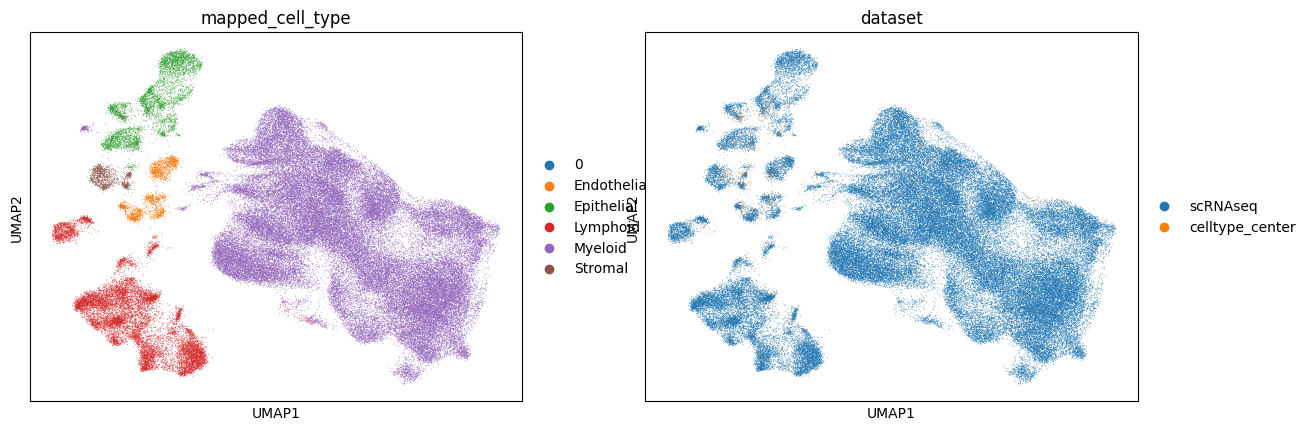

In [ ]:
sc.pl.umap(concat_ad, color=['mapped_cell_type', 'dataset'] )

In [268]:
healthy_human_lung.obsm['X_uce'].min(axis=0), healthy_human_lung.obsm['X_uce'].max(axis=0)

(array([-0.10440952, -0.09936623, -0.06736035, ..., -0.10066272,
        -0.04801935, -0.07755798], dtype=float32),
 array([0.04490222, 0.03954226, 0.08342213, ..., 0.05921483, 0.06955586,
        0.08280513], dtype=float32))

In [176]:
cell_type_ad.obsm['X_uce']

tensor([[-0.0384, -0.0259, -0.0078,  ..., -0.0076,  0.0198,  0.0029],
        [-0.0209, -0.0514,  0.0125,  ...,  0.0087, -0.0009, -0.0025],
        [-0.0569, -0.0293,  0.0217,  ..., -0.0313,  0.0192,  0.0227],
        [-0.0615, -0.0313,  0.0221,  ..., -0.0281,  0.0021,  0.0191],
        [-0.0514, -0.0488,  0.0161,  ..., -0.0104,  0.0048, -0.0317]])